# Capstone Project: Comment Subtopics Analysis for Airbnb Hosts
---

How can a host on Airbnb understand that are their strengths and weaknesses? How can hosts point out the demand trend of their customers from a large scale of comments? This project focuses on using machine learning tools to help hosts understand the underlying trends of the comments on their property.  

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Capstone-Project:-Comment-Subtopics-Analysis-for-Airbnb-Hosts" data-toc-modified-id="Capstone-Project:-Comment-Subtopics-Analysis-for-Airbnb-Hosts-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Capstone Project: Comment Subtopics Analysis for Airbnb Hosts</a></span></li><li><span><a href="#Part-6:-Alternative-Model:-Sentiment-Analysis" data-toc-modified-id="Part-6:-Alternative-Model:-Sentiment-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 6: Alternative Model: Sentiment Analysis</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Steps" data-toc-modified-id="Steps-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Steps</a></span></li></ul></li><li><span><a href="#Sentiment" data-toc-modified-id="Sentiment-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Sentiment</a></span></li><li><span><a href="#Model-Preprocessing" data-toc-modified-id="Model-Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model Preprocessing</a></span></li><li><span><a href="#LSTM-Model-For-Review-Sentiment-Prediction" data-toc-modified-id="LSTM-Model-For-Review-Sentiment-Prediction-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LSTM Model For Review Sentiment Prediction</a></span></li></ul></li></ul></div>


# Part 6: Alternative Model: Sentiment Analysis

- Regression model for predicting score didn't give us much luck. In this notebook, we focus on changing the model to a classification model.
---

### Steps 
1. Find average sentiment for each listing 
2. X: comment, y: average sentiment 
3. Build model 

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [130]:
review_prediction_df = pd.read_csv('../data/clean_comments.csv', index_col = 0)

In [131]:
review_prediction_df.head()

,listing_id,comment,overall_score
0,958,our experience was without a doubt a five st...,97.0
1,5858,we had a fabulous time staying with philip and...,98.0
2,7918,my stay was fantastic the neighborhood is gr...,85.0
3,8142,excellent the space is clean and quiet and t...,93.0
4,8339,my stay was wonderful in many ways; the apartm...,97.0


In [132]:
review_prediction_df.describe()

,listing_id,overall_score
count,4.008000e+03,4008.000000
mean,9.513213e+06,95.506487
std,7.096811e+06,6.109349
min,9.580000e+02,20.000000
25%,2.539666e+06,94.000000
50%,8.487845e+06,97.000000
75%,1.594411e+07,99.000000
max,2.181282e+07,100.000000


## Sentiment

In [133]:
review_sentiment_df = pd.read_csv('../data/reviews_sentiment_score.csv')

In [134]:
review_sentiment_df.head()

,Unnamed: 0,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,overall_rating,compound,neg,neu,pos
0,0,0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",en,97.0,0.9590,0.000,0.788,0.212
1,1,1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,en,97.0,0.9819,0.000,0.697,0.303
2,2,2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,en,97.0,0.7600,0.134,0.710,0.156
3,3,3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,en,97.0,0.9840,0.035,0.646,0.319
4,4,4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,en,97.0,0.9617,0.000,0.613,0.387


In [135]:
compound_df = review_sentiment_df[['listing_id', 'compound']].groupby(by = ['listing_id']).mean()

In [137]:
compound_df.head()

,compound
listing_id,
958,0.905033
5858,0.882490
7918,0.959018
8142,0.981643
8339,0.948511


In [139]:
review_prediction_df = review_prediction_df.merge(compound_df, left_on = "listing_id", right_on = 'listing_id')

In [143]:
review_prediction_df.shape

(4008, 4)

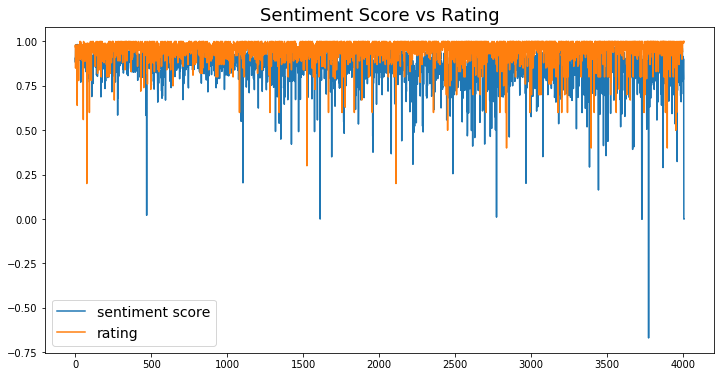

In [236]:
plt.figure(figsize = (12, 6))
plt.plot(review_prediction_df['compound'], label = 'sentiment score')
plt.plot(review_prediction_df['overall_score']/100, label = 'rating')
plt.title("Sentiment Score vs Rating", fontsize = 18)
plt.legend(fontsize = 14);

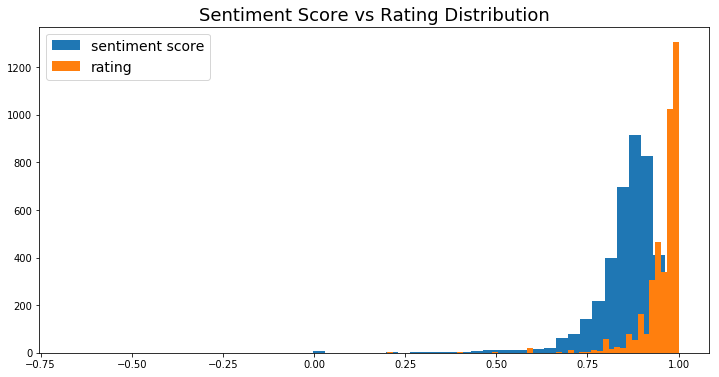

In [235]:
plt.figure(figsize = (12, 6))
plt.hist(review_prediction_df['compound'], bins = 50, label = 'sentiment score')
plt.hist(review_prediction_df['overall_score']/100, bins = 50, label = 'rating')
plt.title("Sentiment Score vs Rating Distribution", fontsize = 18)
plt.legend(fontsize = 14);

## Model Preprocessing 
---

In [250]:
#tokenizing the data 
vocabulary_size = 50000
max_sequence = 3000 

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(review_prediction_df['comment'].values)

In [251]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 65973 unique tokens.


In [252]:
X = tokenizer.texts_to_sequences(review_prediction_df['comment'].values)
X = pad_sequences(X, maxlen= max_sequence)

In [253]:
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4008, 3000)


In [254]:
y = review_prediction_df['compound']
print('Shape of target:', y.shape)

Shape of target: (4008,)


In [255]:
#Train_test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3206, 3000) (3206,)
(802, 3000) (802,)


In [256]:
pt = PowerTransformer()
X_train_pt = pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)

## LSTM Model For Review Sentiment Prediction

In [267]:
#building model 
model = Sequential()

model.add(Dense(1200, activation = 'relu', input_shape = (3000,)))

model.add(Dense(600, activation = 'relu'))

model.add(Dense(300, activation = 'relu'))

model.add(Dense(120, activation = 'relu'))

model.add(Dense(64, activation = 'relu'))

model.add(Dense(32, activation = 'relu' ))

model.add(Dense(12, activation = 'relu' ))

#output layer 
model.add(Dense(1))

#adjust learning rate
# adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
adam = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
# RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer= adam, loss='mean_absolute_error', metrics=['mean_absolute_error'])

epochs = 20
batch_size = 86

history = model.fit(X_train_pt, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 2885 samples, validate on 321 samples
Epoch 1/20
2885/2885 [==============================] - 12s 4ms/step - loss: 1.3205 - mean_absolute_error: 1.3205 - val_loss: 0.8375 - val_mean_absolute_error: 0.8375
Epoch 2/20
2885/2885 [==============================] - 4s 2ms/step - loss: 0.3019 - mean_absolute_error: 0.3019 - val_loss: 0.0976 - val_mean_absolute_error: 0.0976
Epoch 3/20
2885/2885 [==============================] - 4s 2ms/step - loss: 0.0878 - mean_absolute_error: 0.0878 - val_loss: 0.0735 - val_mean_absolute_error: 0.0735
Epoch 4/20
2885/2885 [==============================] - 4s 2ms/step - loss: 0.0702 - mean_absolute_error: 0.0702 - val_loss: 0.0767 - val_mean_absolute_error: 0.0767
Epoch 5/20
2885/2885 [==============================] - 5s 2ms/step - loss: 0.0630 - mean_absolute_error: 0.0630 - val_loss: 0.0699 - val_mean_absolute_error: 0.0699
Epoch 6/20
2885/2885 [==============================] - 6s 2ms/step - loss: 0.0632 - mean_absolute_error: 0.0632 - val_los

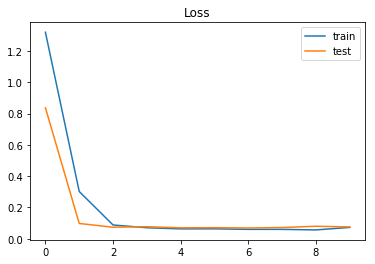

In [268]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

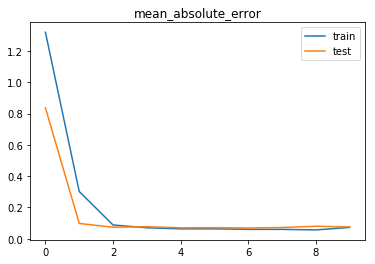

In [269]:
plt.title('mean_absolute_error')
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='test')
plt.legend()
plt.show();

In [270]:
prediction = model.predict(X_test_pt)

In [271]:
#building prediction DataFrame
prediction_df = pd.DataFrame(data = prediction, columns= ['prediction'])

prediction_df['y_test'] = y_test.values

prediction_df['difference'] = prediction_df['prediction'] - prediction_df['y_test']

In [272]:
prediction_df.head()

,prediction,y_test,difference
0,0.895857,0.816289,0.079568
1,0.816125,0.803433,0.012692
2,0.859045,0.813400,0.045645
3,0.824775,0.831277,-0.006502
4,0.925269,0.885399,0.039870


In [273]:
from sklearn import metrics
metrics.r2_score(prediction_df['y_test'], prediction_df['prediction'])

-0.32601102700073326